In [1]:
from pathlib import Path
from itertools import groupby
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

from resemblyzer import preprocess_wav, VoiceEncoder
from demo_utils import *

In [2]:
# encoder = VoiceEncoder(ckpt_path='/home/ubuntu/speaker-recognition/Real-Time-Voice-Cloning/encoder/saved_models/clv.pt')
encoder = VoiceEncoder(ckpt_path='/home/ubuntu/speaker-recognition/Resemblyzer/ckpt/pretrained.pt')

# wav_fpaths = list(Path("audio_data", "librispeech_test-other").glob("**/*.flac"))
wav_fpaths = list(Path("../../data/clv").glob("**/*.wav"))
# print(wav_fpaths)

# Group the wavs per speaker and load them using the preprocessing function provided with
# resemblyzer to load wavs in memory. It normalizes the volume, trims long silences and resamples
# the wav to the correct sampling rate.
speaker_wavs = {
    speaker: list(map(preprocess_wav, wav_fpaths))
    for speaker, wav_fpaths in groupby(
        tqdm(wav_fpaths, "Preprocessing wavs", len(wav_fpaths), unit="wavs"),
        lambda wav_fpath: wav_fpath.parent.stem)
}
print(speaker_wavs)

Preprocessing wavs:   0%|          | 0/324 [00:00<?, ?wavs/s]

Loaded the voice encoder model on cuda in 1.82 seconds.


Preprocessing wavs: 100%|██████████| 324/324 [00:50<00:00,  6.43wavs/s]

{'ThuongTran': [array([ 0.00336948,  0.00373557,  0.00579899, ..., -0.02040021,
       -0.01768974, -0.02024408], dtype=float32), array([-0.0243271 , -0.02399345, -0.02404143, ..., -0.0042414 ,
       -0.00209182,  0.00248204], dtype=float32), array([-0.01465794, -0.01266111, -0.00964898, ...,  0.01259205,
        0.01245434,  0.01060098], dtype=float32), array([0.0003048 , 0.0006867 , 0.00141274, ..., 0.03221355, 0.02981883,
       0.02877471], dtype=float32), array([-0.00992309, -0.01211945, -0.00965828, ..., -0.00081473,
       -0.00027864,  0.00036679], dtype=float32), array([-0.00611822, -0.00634095, -0.00539956, ..., -0.02620837,
       -0.02581597, -0.02795815], dtype=float32), array([-0.00396819, -0.00509524, -0.00635265, ...,  0.02240982,
        0.02162561,  0.02297194], dtype=float32), array([ 0.00792698,  0.00730303,  0.00586012, ..., -0.01038037,
       -0.01022512, -0.00852792], dtype=float32), array([0.01672906, 0.01909938, 0.02195628, ..., 0.02660086, 0.02356832,
      

In [3]:
# dvects_dict = np.load('/home/ubuntu/speaker-recognition/SincNet/exp/SincNet_clv/d_vect.npy', allow_pickle=True)
# dvects_list = []
# speakers = []
# for key in dvects_dict.item():
#     dvects = dvects_dict.item()[key]
#     for dvect in dvects:
#         if np.isnan(np.sum(dvect)):
#             continue
#         speakers.append(key)
#         dvects_list.append(dvect)
# ## Project the embeddings in 2D space
# plot_projections(dvects_list, speakers, title="Embedding projections")
# plt.show()

/home/ubuntu/anaconda3/envs/resemblyzer/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


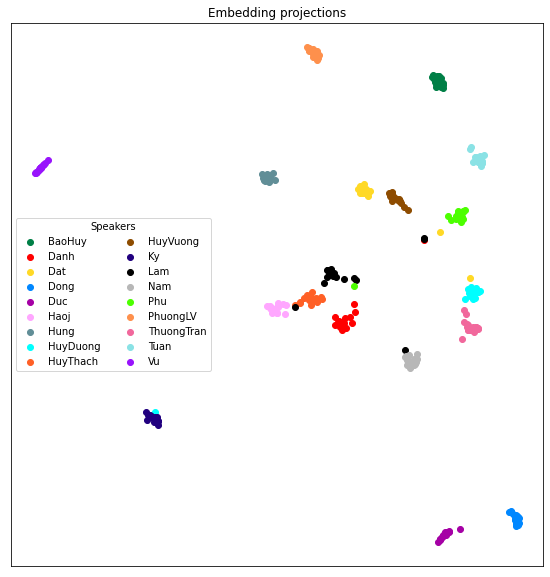

In [4]:
## Compute the embeddings
# utterance_embeds = np.array(list(map(encoder.embed_utterance, wavs)))
utterance_embeds = []
for wavs in speaker_wavs.values():
    for wav in wavs:
        utterance_embeds.append(encoder.embed_utterance(wav))
utterance_embeds = np.array(utterance_embeds)
# print(utterance_embeds[0])
speakers = list(map(lambda wav_fpath: wav_fpath.parent.stem, wav_fpaths))

###
# print(speakers, len(speakers))
# print(len(utterance_embeds))
###
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# sc.fit(utterance_embeds)
# utterance_embeds = sc.transform(utterance_embeds)
###

## Project the embeddings in 2D space
plot_projections(utterance_embeds, speakers, title="Embedding projections")
plt.show()

In [5]:
# np.save('/home/ubuntu/speaker-recognition/embeds_from_pre.npy', utterance_embeds)
# np.save('/home/ubuntu/speaker-recognition/labels_from_pre.npy', speakers)

In [6]:
## Similarity between two utterances from each speaker
# Embed two utterances A and B for each speaker
i = np.random.randint(0, 18)
j = np.random.randint(0, 18)
print(i, j)
embeds_a = np.array(
    [encoder.embed_utterance(wavs[i]) for wavs in speaker_wavs.values()])
embeds_b = np.array(
    [encoder.embed_utterance(wavs[j]) for wavs in speaker_wavs.values()])
# Each array is of shape (num_speakers, embed_size) which should be (10, 256) if you haven't
# changed anything.
print("Shape of embeddings: %s" % str(embeds_a.shape))

# Compute the similarity matrix. The similarity of two embeddings is simply their dot
# product, because the similarity metric is the cosine similarity and the embeddings are
# already L2-normed.
# Short version:
utt_sim_matrix = np.inner(embeds_a, embeds_b)
# print(utt_sim_matrix)

# # Long, detailed version:
# utt_sim_matrix2 = np.zeros((len(embeds_a), len(embeds_b)))
# for i in range(len(embeds_a)):
    # for j in range(len(embeds_b)):
        # # The @ notation is exactly equivalent to np.dot(embeds_a[i], embeds_b[i])
        # utt_sim_matrix2[i, j] = embeds_a[i] @ embeds_b[j]
# assert np.allclose(utt_sim_matrix, utt_sim_matrix2)

## Similarity between two speaker embeddings
# Divide the utterances of each speaker in groups of identical size and embed each group as a
# speaker embedding
spk_embeds_a = np.array([encoder.embed_speaker(wavs[:len(wavs) // 2]) \
                         for wavs in speaker_wavs.values()])
spk_embeds_b = np.array([encoder.embed_speaker(wavs[len(wavs) // 2:]) \
                         for wavs in speaker_wavs.values()])
spk_sim_matrix = np.inner(spk_embeds_a, spk_embeds_b)

8 8
Shape of embeddings: (18, 256)


/home/ubuntu/anaconda3/envs/resemblyzer/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


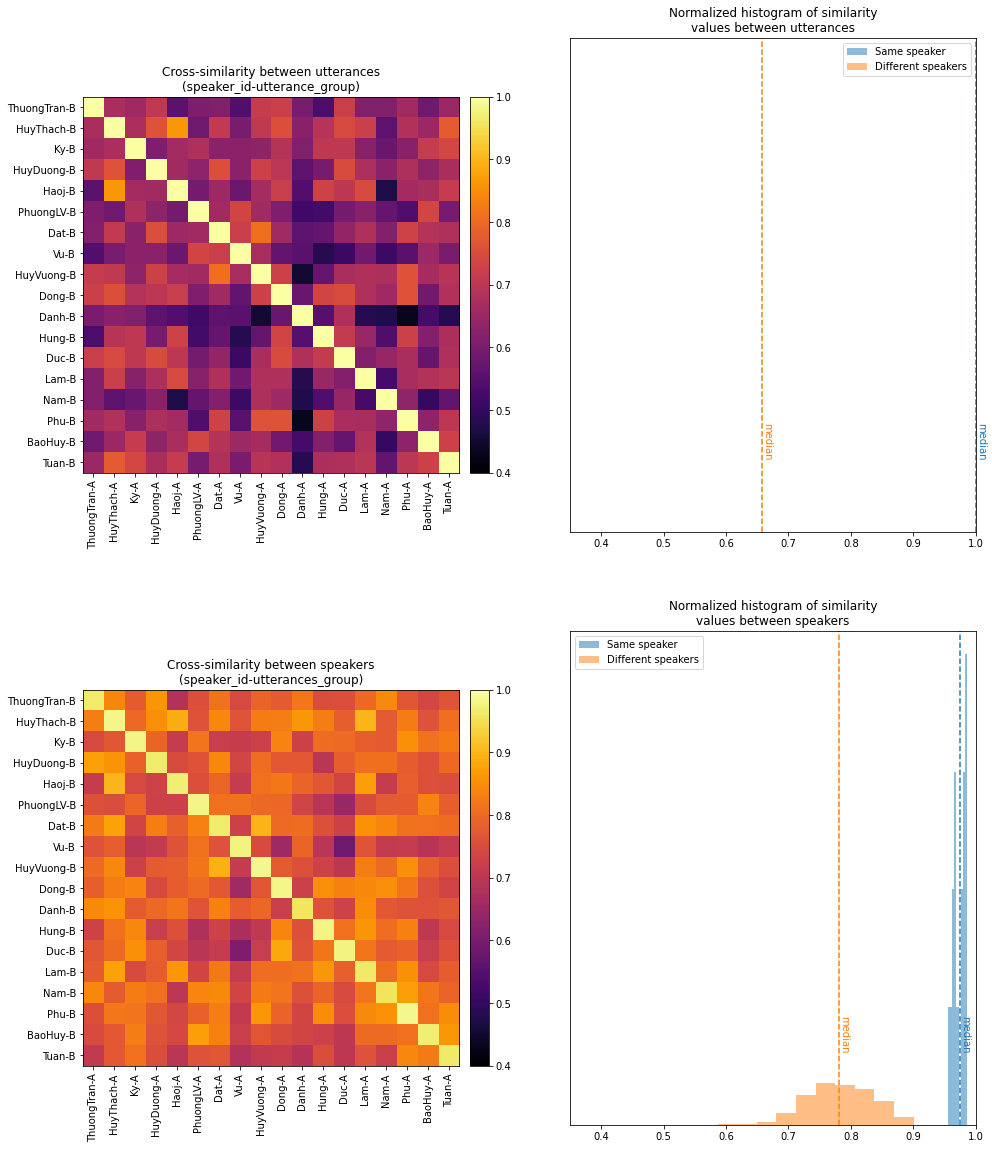

In [7]:
## Draw the plots
fix, axs = plt.subplots(2, 2, figsize=(16, 20))
labels_a = ["%s-A" % i for i in speaker_wavs.keys()]
labels_b = ["%s-B" % i for i in speaker_wavs.keys()]
mask = np.eye(len(utt_sim_matrix), dtype=np.bool)
plot_similarity_matrix(
    utt_sim_matrix, labels_a, labels_b, axs[0, 0],
    "Cross-similarity between utterances\n(speaker_id-utterance_group)")
plot_histograms(
    (utt_sim_matrix[mask], utt_sim_matrix[np.logical_not(mask)]), axs[0, 1],
    ["Same speaker", "Different speakers"],
    "Normalized histogram of similarity\nvalues between utterances")
plot_similarity_matrix(
    spk_sim_matrix, labels_a, labels_b, axs[1, 0],
    "Cross-similarity between speakers\n(speaker_id-utterances_group)")
plot_histograms((spk_sim_matrix[mask], spk_sim_matrix[np.logical_not(mask)]),
                axs[1, 1], ["Same speaker", "Different speakers"],
                "Normalized histogram of similarity\nvalues between speakers")
plt.show()